In [1]:
from pyspark.sql.functions import col, sum as spark_sum, when, isnan, isnull, lit, trim, initcap, year, avg, month, countDistinct, date_format, to_date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = spark.sql("SELECT * FROM My_Workspace.testing.dbo.publicholidays")

display(df.limit(5))

StatementMeta(, c70399e0-c712-4cb2-bc41-e675fefbfbce, 6, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9183504f-795a-446e-991e-1e3b6b68647f)

In [2]:
#df info
df.printSchema()

#check missing values
missing_check = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
display(missing_check)

#duplicate check
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")


StatementMeta(, c70399e0-c712-4cb2-bc41-e675fefbfbce, 8, Finished, Available, Finished)

root
 |-- countryOrRegion: string (nullable = true)
 |-- holidayName: string (nullable = true)
 |-- normalizeHolidayName: string (nullable = true)
 |-- isPaidTimeOff: boolean (nullable = true)
 |-- countryRegionCode: string (nullable = true)
 |-- date: timestamp (nullable = true)



SynapseWidget(Synapse.DataFrame, e453fabe-2a66-41e6-9f7c-20eb1b201d5c)

Number of duplicate rows: 0


In [3]:
#missing value handling
#isPaidTimeOff with false
df = df.withColumn("isPaidTimeOff", when(isnull(col("isPaidTimeOff")), False).otherwise(col("isPaidTimeOff")))

#countryRegionCode with their example value for each country
df = df.withColumn("countryOrRegion_clean", initcap(trim(col("countryOrRegion"))))

country_region_defaults = {
  "Australia": "AU",
  "Austria": "AT",
  "Belgium": "BE",
  "Brazil": "BR",
  "Canada": "CA",
  "Croatia": "HR",
  "Denmark": "DK",
  "Finland": "FI",
  "Hungary": "HU",
  "Ireland": "IE",
  "Isle of Man": "IM",
  "Italy": "IT",
  "Japan": "JP",
  "Netherlands": "NL",
  "New Zealand": "NZ",
  "Portugal": "PT",
  "South Africa": "ZA",
  "Spain": "ES",
  "Sweden": "SE",
  "Switzerland": "CH",
  "United Kingdom": "GB",
  "United States": "US",
  "England": "GB",
  "Northern Ireland" : "GB",
  "Scotland": "GB",
  "Wales": "GB"
}

mapping_condition = None
for country, code in country_region_defaults.items():
    if mapping_condition is None:
        mapping_condition = when(col("countryOrRegion_clean") == country, code)
    else:
        mapping_condition = mapping_condition.when(col("countryOrRegion_clean") == country, code)

mapping_condition = mapping_condition.otherwise(col("countryRegionCode"))

df = df.withColumn("countryRegionCode", 
    when(
        (col("countryRegionCode").isNull()) | (col("countryRegionCode") == ""), 
        mapping_condition
    ).otherwise(col("countryRegionCode"))
)

df = df.drop("countryOrRegion_clean")

#display missing value after handling
missing_check_after = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
display(missing_check_after)

StatementMeta(, c70399e0-c712-4cb2-bc41-e675fefbfbce, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d099de2d-4f03-425f-9952-4efe3e73b9c6)

StatementMeta(, f81bf753-8fa0-4d77-b851-961c78aad593, 11, Finished, Available, Finished)

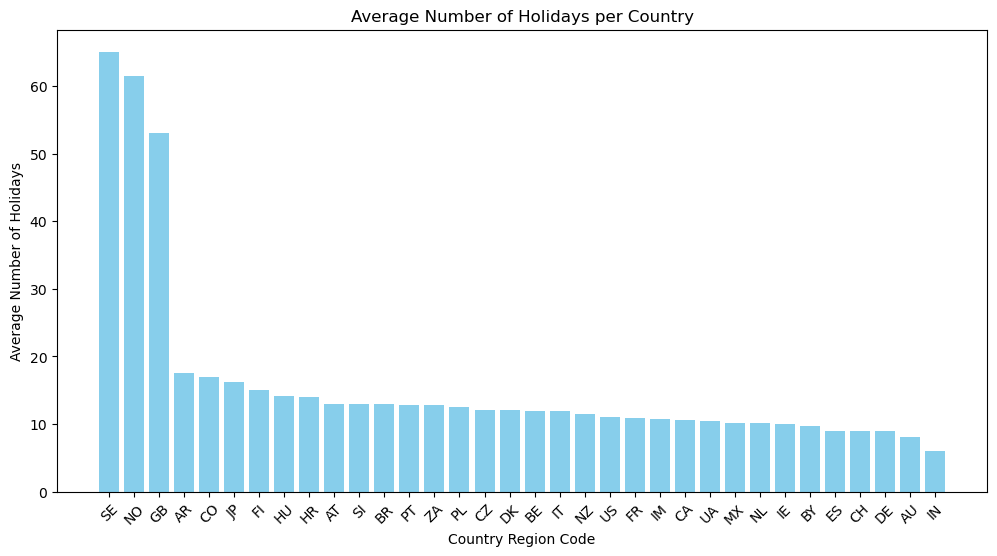

StatementMeta(, c70399e0-c712-4cb2-bc41-e675fefbfbce, 11, Finished, Available, Finished)

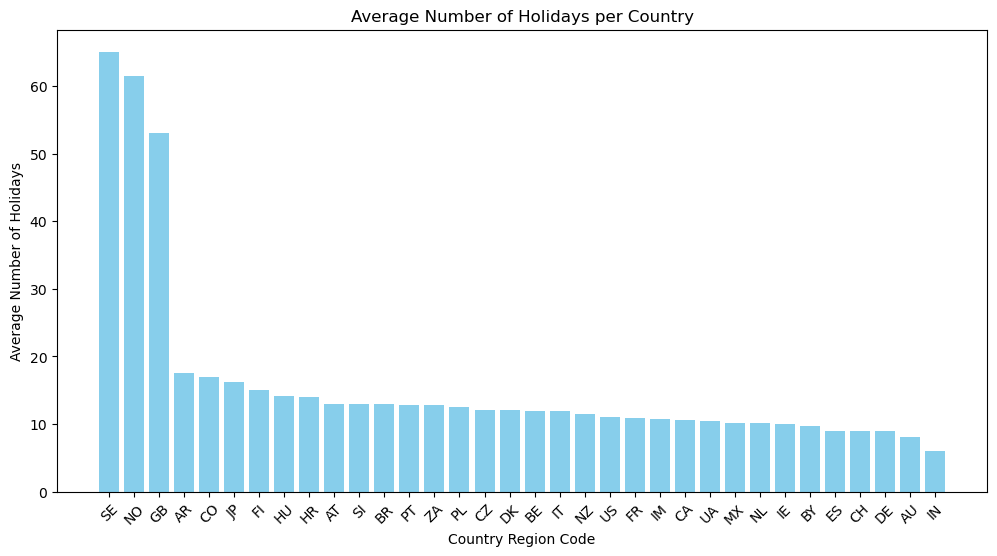

In [4]:
#data visualization

# average number of holidays per country Bar Chart from the biggest to smallest

df_year = df.withColumn("year", year(col("date")))
holidays_per_year = df_year.groupBy("countryRegionCode", "year").count()
avg_holidays_per_country = holidays_per_year.groupBy("countryRegionCode").agg(avg("count").alias("avg_holidays")).orderBy(col("avg_holidays").desc())
avg_holidays_pd = avg_holidays_per_country.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(avg_holidays_pd['countryRegionCode'], avg_holidays_pd['avg_holidays'], color='skyblue')
plt.xlabel('Country Region Code')
plt.ylabel('Average Number of Holidays')
plt.title('Average Number of Holidays per Country')
plt.xticks(rotation=45)
plt.show()

Insights:
1. The biggest average number of holidays  is in SE (Sweden) with more than 60 holidays per year.
2. The smallest average number of holidays is in IN (India) with lower than 10 holidays per year.
3. TOP 5 countries with the biggest average number of holidays: SE, NO, GB, AR, CO

StatementMeta(, c70399e0-c712-4cb2-bc41-e675fefbfbce, 13, Finished, Available, Finished)

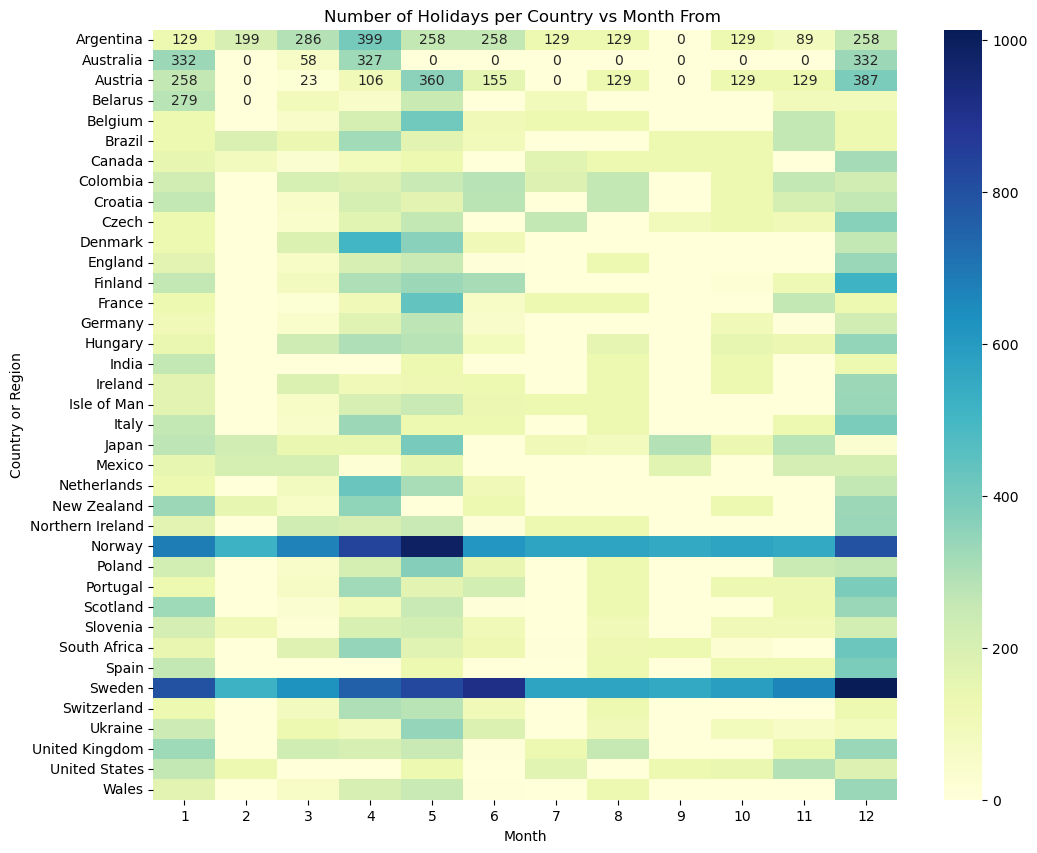

In [5]:
# heatmap country vs month Y is CountryOrRegion and X is month, color is showing number of holidays

df_month = df.withColumn("month", month(col("date")))
holidays_per_month = df_month.groupBy("countryOrRegion", "month").count()
holidays_per_month_pd = holidays_per_month.toPandas()
heatmap_data = holidays_per_month_pd.pivot(index = "countryOrRegion", columns = "month", values = "count")
heatmap_data = heatmap_data.fillna(0).astype(int)
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Number of Holidays per Country vs Month From ')
plt.xlabel('Month')
plt.ylabel('Country or Region')
plt.show()

Insights:
1. Heatmap shows that high concentration of holidays across almost all countries in December to January.
2. There is a distinct cluster of holidays in May for European countries (likely due to Labor Day, Ascension Day, or Whit Monday), whereas non-European regions (like the US or Japan) show lighter schedules during this month.
3. Months such as February, September, and October appear relatively "light" (fewer holidays) across most regions represented in the dataset.

StatementMeta(, c70399e0-c712-4cb2-bc41-e675fefbfbce, 14, Finished, Available, Finished)

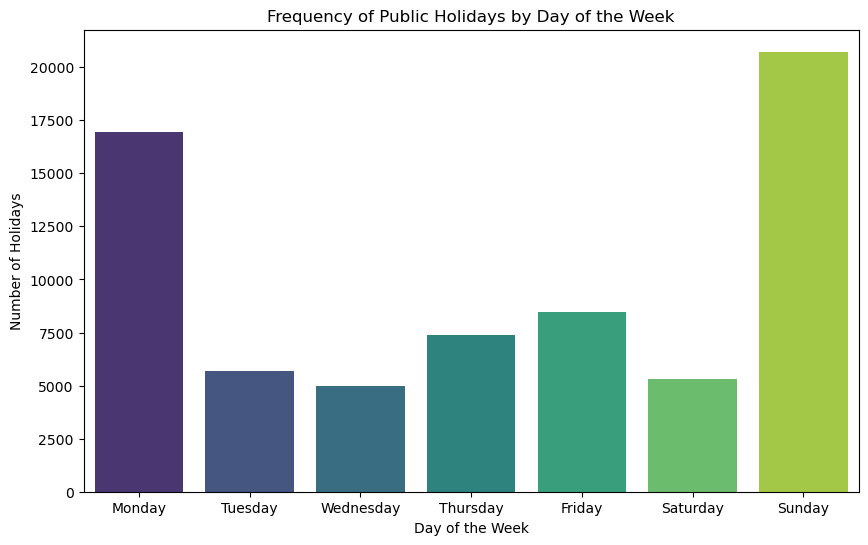

In [ ]:
# bar chart day of week vs frequency of holidays

df = df.withColumn("date", to_date(col("date")))
df = df.withColumn("day_of_week", date_format(col("date"), "EEEE"))
day_of_week_count = df.groupBy("day_of_week").count()
day_of_week_pd = day_of_week_count.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=day_of_week_pd, x="day_of_week", y="count", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], palette="viridis")
plt.title('Frequency of Public Holidays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Holidays')
plt.show()

Insights :
1. High frequency of holidays occur on Fridays and Mondays, indicating a trend towards long weekends.
2. Significant bar on sunday mean many holidays fall on weekends.